In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr
sys.path.insert(0, os.path.abspath('../src'))
from ray_vapor import RayVapor, Camera#, Guess
###################################
import scipy as sp
from scipy.optimize import minimize
import time

In [2]:
rv_data = xr.open_mfdataset('input/qvapor_slice.nc', combine='by_coords')
y=108
num_obs=20
nz = len(rv_data.bottom_top) - 1 #* 0.8
camera = Camera() # defaults to camera angles at 90+-40 degrees at 5 degree increments
rv = RayVapor(rv_data, camera, num_obs=num_obs, z=nz)

In [3]:
camera.ray_angles

[50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130]

In [4]:
rv.compute_obs()

- first compute, angles being saved for future computation


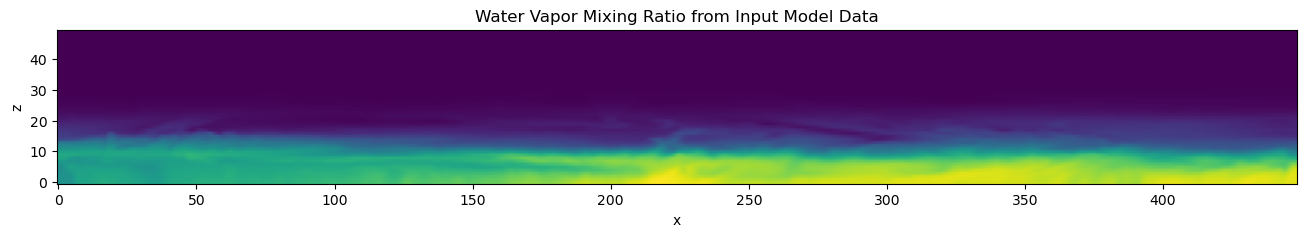

In [5]:
rv.plot_env()

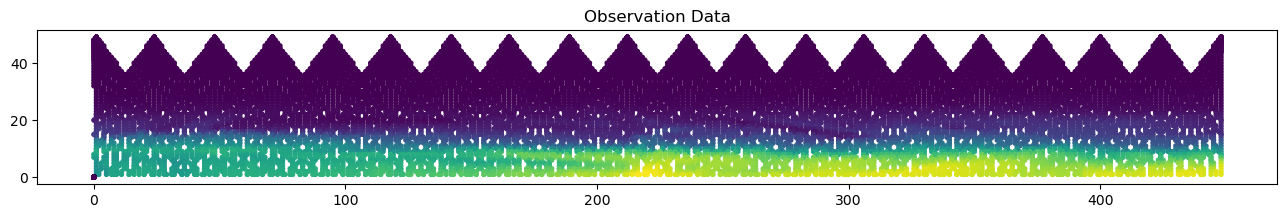

In [6]:
### Plotting the observations is a dot plot of the values collled
rv.plot_obs()

In [9]:
#######################################################################
#######################################################################
###                     Reconstruction                              ###
#######################################################################
#######################################################################

In [21]:
global mod
mod=10
global num_iterations
#q_nx = round((rv.get_target_end()-rv.get_target_start()) / mod)
q_nx = round(rv.nx / mod)
q_nz = round(rv.nz / mod)
num_obs = rv.num_obs
y=108 # from prep file of qvapor slice

def callback(xk):
    global num_iterations
    num_iterations += 1
    
# Initialize the number of iterations counter
def objective(qv_guess):
    global num_iterations
    qv_guess = qv_guess.reshape(q_nz,1,q_nx).repeat(mod,axis=0).repeat(mod,axis=2) #.repeat(2,axis=1).shape

    qv_guess = qv_guess[:,:,:-1] # should this be [:,:,:nz]?
    rv_guess = RayVapor(qv_guess, camera, num_obs=num_obs, z=nz)
    rv_guess.copy_rv_setup(rv)
    rv_guess.compute_obs() # triple check the updated observation is being used here

    err = np.mean((rv.qvapor_integrations_flat - rv_guess.qvapor_integrations_flat)**2)

    if num_iterations%1000 == 0:
        print(num_iterations, ": err", err)
    num_iterations += 1
    return err


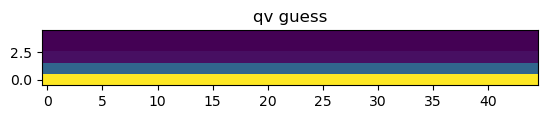

In [12]:
global num_iterations
qv_max = 0.04

## --- old qv_guess creation method
#qv_guess = np.random.random((q_nz, q_nx))* (qv_max/(q_nz*3))
#qv_guess = np.flip(np.cumsum(qv_guess, axis=0), axis=0)

# --- setup qv_guess
qv_guess, q_nx, q_nz = rv.guess_setup('average_vertical_profile_from_obs', mod=mod)
saved_qv_guess = qv_guess

# --- setup for minization method
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# subset of methods that worked best during initial testing
bounds = [(0, qv_max)]# * q_nx * q_nz
solutions = np.zeros((rv.num_obs, q_nx * q_nz))
methods = ['Nelder-Mead','Powell']

In [20]:
debugging = False
if (debugging):
    m = 'Nelder-Mead'
    tol = 0.01
    num_iterations = 200
    num_iterations = 0
    max_iter = 200
    result = minimize(objective, saved_qv_guess, bounds=bounds, method=m, tol=tol, options={'maxiter':max_iter}, callback=callback)

--- coarse environment ---


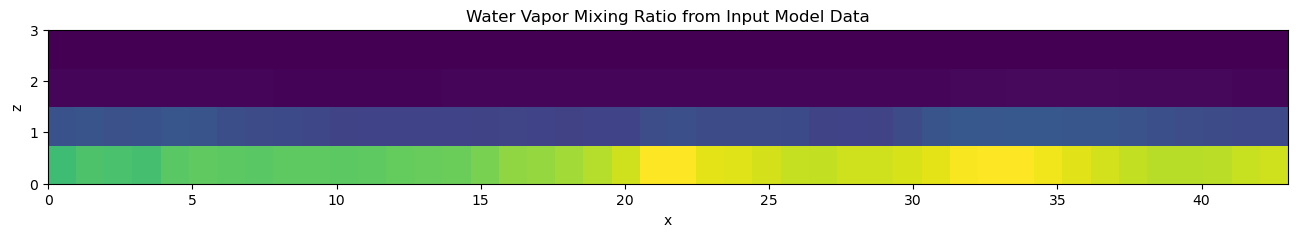

mod =  10
---------
starting Nelder-Mead
0 : err 0.00028594530311309784
: successful method Nelder-Mead took 2.81 sec and 227 iterations


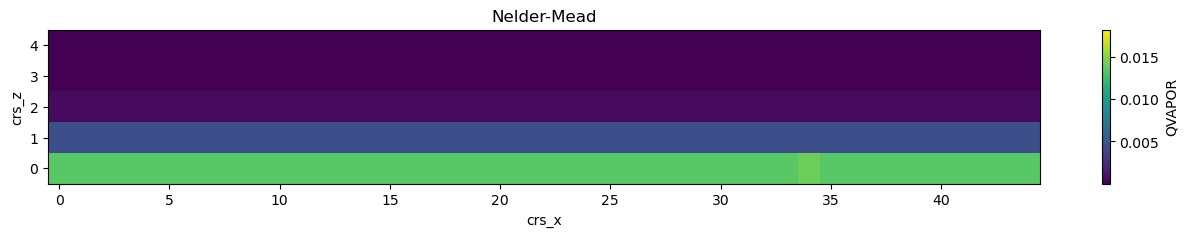

saving to rv_Nelder-Mead_10mod_0.001tol_226iter.nc
---------
starting Powell
0 : err 0.00028594530311309784
1000 : err 0.0005214718366387686
2000 : err 0.0001182636025839569
3000 : err 0.001248003975034969
4000 : err 9.449561739010231e-05
5000 : err 6.230692315158692e-05
6000 : err 7.87393310452973e-05
7000 : err 6.568949736341975e-05
8000 : err 4.457186451951335e-05
9000 : err 4.3887461613627655e-05
10000 : err 4.9380980253313645e-05
: successful method Powell took 137.74 sec and 10980 iterations


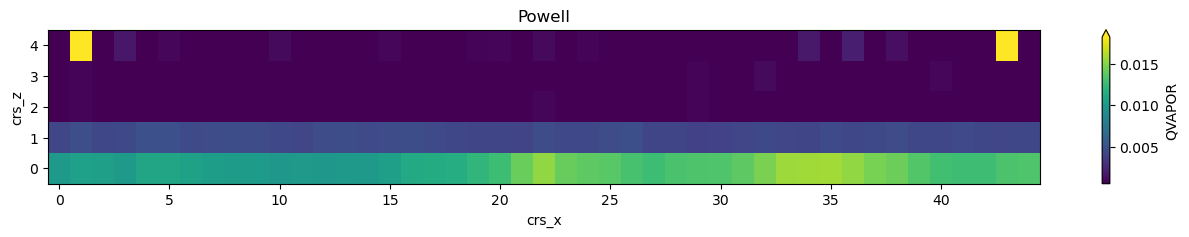

saving to rv_Powell_10mod_0.001tol_10974iter.nc


In [22]:
# with bounds: 20 obs, lower tolerance, 0.001 didn't finish in the previous run
# with mod=10
print('--- coarse environment ---')
rv.plot_env(mod=mod)
print('mod = ', str(mod))
qv_max = rv.qvapor.max()
tol = 0.001
num_iterations = 200


for m in methods:
    print('---------')
    print('starting', m)
    num_iterations = 0
    max_iter = 200
    try:
        start_t = time.time()
        #result = minimize(objective, saved_qv_guess, method=m, tol=tol, options={'maxiter':max_iter}, callback=callback)
        result = minimize(objective, saved_qv_guess, bounds=bounds, method=m, tol=tol, options={'maxiter':max_iter}, callback=callback)
        end_t = time.time()
        total_t = end_t - start_t
    except Exception as error:
        print('failed method:', m,'raised exception', error)
    else:
        if result['success'] == True:
            solutions = result['x']
            qv_guess = result['x']
            print(': successful method '+str(m)+' took {:.2f} sec'.format(total_t)+' and '+str(num_iterations)+' iterations')
            
            rv.set_solution(result, m, tol, mod, q_nx, q_nz, total_t, env_south_north=y)
            rv.plot_solution(qv_max=qv_max)
            rv.save_solution()
        else:
            print('failed method:', m)